# DS2 Take-Home Assignment - Nicolas Fernandez
### Kaggle Competition - Predicting Online News Popularity
The task is to create the best possible model for predicting the popularity of a news article from mashable.com and perform best in a kaggle.com competition being held.

The dataset being used can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/data) and a link to the kaggle competition overview can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/overview).

The data itself, as mentioned above, comes from mashable.com and is data from articles that appeared on the site two years past January 8, 2015 (when the dataset was acquired) or later. The goal is to predict which articles are shared the most on social media using the binary `is_popular` column within the dataset denoting an article being popular with a 1, 0 if not. From the competition, the data is already split into `train.csv` and `test.csv` with the latter being used to generate predictions on popularity for submission to the competition. `train.csv` will be split into training and test sets for creating and testing predictive models.

## Loading Data and EDA

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

# Loading train data from csv locally and viewing the contents
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

There are no NaN values within the data however there could imputed values that can be interpreted as missing. This will be explored further. Along with this, per the dataset column descriptions on Kaggle, there are certain columns that are either difficult to interpret or can be considered superfluous, for instance all of the `kw` columns except for `kw_avg_avg` which is the average amount of social media shares that the keywords used in the article in question have across all articles. The `self_reference` columns will also be dropped since these refer to the shares to other articles within Mashable but using this would lower external validity of the model since it would only aid prediction of Mashable articles overall.

One question to be explored if a dummy variable is necessary for each day of the week or only weekends are important, and same for the genre of the article.

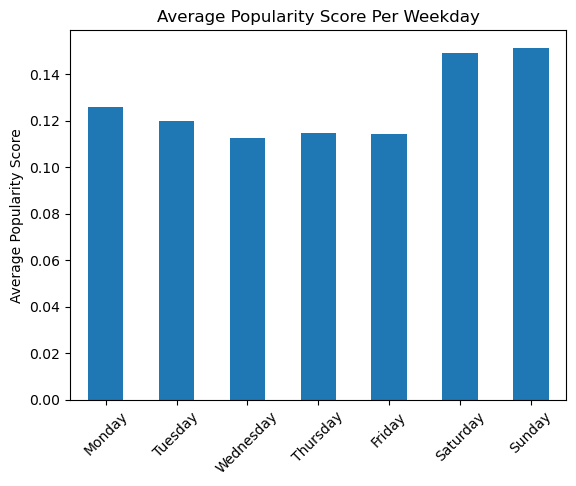

In [2]:
# Importing required libraries
import matplotlib.pyplot as plt

# Creating list of uninterpretable and/or superfluous columns from data
drop_cols = []
for col in data.columns:
    if col.startswith('n_non_'):
        drop_cols.append(col)
    elif 'hrefs' in col:
        drop_cols.append(col)
    elif col.startswith('kw_') and col != 'kw_avg_avg':
        drop_cols.append(col)
    elif col.startswith('self_'):
        drop_cols.append(col)
    elif col.startswith('LDA_'):
        drop_cols.append(col)
    elif 'polarity' in col and not col.startswith('avg') and not col.startswith('global_') and not col.startswith('title'):
        drop_cols.append(col)
    elif 'subjectivity' in col and not col.startswith('global') and not col.startswith('title'):
        drop_cols.append(col)

# Dropping columns from list created above
data.drop(columns=drop_cols, inplace=True)

# Getting all weekday columns set to a list
weekdays = [col for col in data.columns if col.startswith('weekday_')]
weekday_names = [day.replace('weekday_is_', '').capitalize() for day in weekdays]

# Creating dataframe that shows average popularity score for each weekday
avg_weekday_pop_df = data.groupby(weekdays)['is_popular'].mean()[::-1]

# Creating a bar plot to show the average scores per weekday
avg_weekday_pop_df.plot(kind='bar')
plt.xlabel(None)
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score Per Weekday')

plt.xticks(range(len(weekday_names)), weekday_names, rotation=45)

plt.show()

From this plot we can see that the most influential days from the data are the weekends (Saturday and Sunday) with the earlier weekdays being slightly more influential than the latter ones. Using this information, the dummy variables for each weekday will be dropped, the already existing `is_weekend` column will be kept but renamed to `d_weekend` to flag it as a dummy variable, and a new dummy variable `d_mon_tues` will be created to flag whether the article was released on either Monday or Tuesday.

Next, the same examination will be done for article genres.

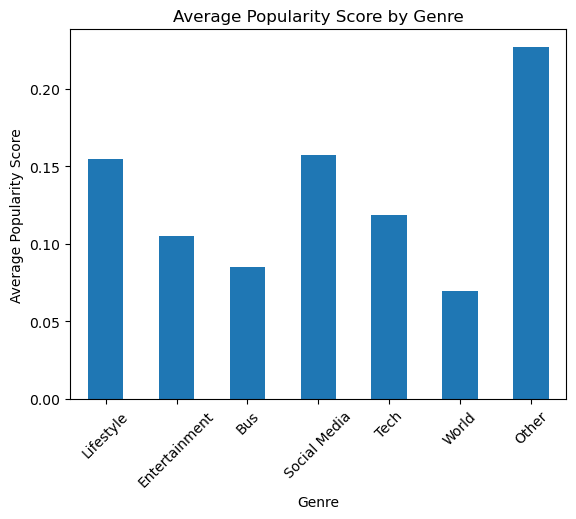

In [3]:
# Creating Monday/Tuesday dummy variable
data['d_mon_tues'] = data['weekday_is_monday'] + data['weekday_is_tuesday']

# Renaming is_weekend to d_weekend
data.rename(columns={'is_weekend': 'd_weekend'}, inplace=True)

# Dropping all weekday_is_ columns from data since they are no longer necessary
data.drop(columns=weekdays, inplace=True)

# Repeating the same plot above but with article genres
genres = [col for col in data.columns if col.startswith('data_channel_is_')]
genre_names = [genre.replace('data_channel_is_', '').capitalize() for genre in genres]
genre_names[genre_names.index('Socmed')] = 'Social Media'
genre_names.append('Other')

genre_pop_df = data.groupby(genres)['is_popular'].mean()[::-1]

genre_pop_df.plot(kind='bar')

plt.xlabel('Genre')
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score by Genre')

plt.xticks(range(len(genre_names)), genre_names, rotation=45)

plt.show()

From reviewing the data there were a couple observations:
- Despite there being 6 genre classifiers in the data there is a 7th occurence for articles that don't fall under any of the labelled genres. For the purposes of the plot they were labelled as `Other`
- Articles not falling into any of the 6 classified genres are significantly more popular than the rest
- Amongst the articles denoted by a specific genre, the `Lifestyle` and `Social Media` genres are the most significant predictors, roughly the same
- The `World` genre appears to be the least popular genre, somewhat significantly so

From this analysis it appears that the genre of the article has significance for determining popularity but that different groupings may not make sense. These columns will be left as is within the data but renamed to flag them as dummy variables with the following syntax: `d_genre_`

Next a histogram of the `average_token_length` will be examined.

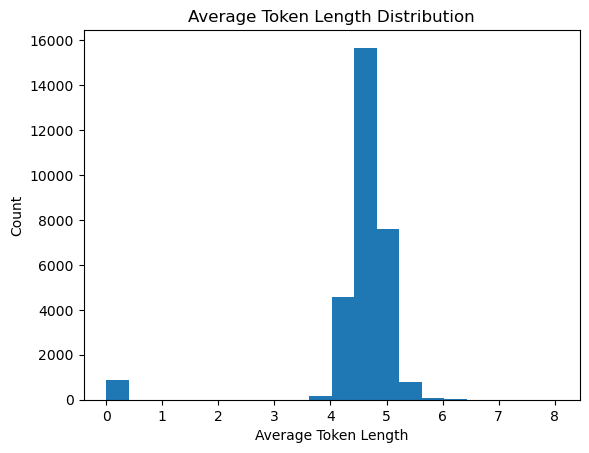

In [4]:
# Renaming genre dummy variables
[data.rename(columns={genre: genre.replace('data_channel_is_', 'd_genre_')}, inplace=True) for genre in genres]

# Generating a historgram of `average_token_length`
plt.hist(data['average_token_length'], bins=20)

plt.xlabel('Average Token Length')
plt.ylabel('Count')
plt.title('Average Token Length Distribution')

plt.show()

From this we can see that the distribution of average token length of articles in the data is approximating a normal distribution around a mean of roughly 4.5. The noteworthy values here are the significant portion of values with an average token length of 0. These occurrences will be explored in more depth to figure out what exactly these represent. It is likely that these articles are slideshows and/or videos rather than traditional prose (or a combination thereof).

In [5]:
# Viewing descriptive statistics for occurences where `average_token_length` equals 0
data[data['average_token_length'] == 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,article_id,d_mon_tues
count,867.000000,867.000000,867.0,867.0,867.000000,867.000000,867.0,867.000000,867.000000,867.000000,...,867.0,867.0,867.0,867.0,867.0,867.000000,867.000000,867.000000,867.000000,867.000000
mean,164.573241,10.850058,0.0,0.0,3.747405,0.792388,0.0,7.471742,0.018454,0.154556,...,0.0,0.0,0.0,0.0,0.0,0.349305,0.088811,0.191465,20136.944637,0.359862
std,167.269141,2.036760,0.0,0.0,8.606464,1.155682,0.0,1.663373,0.134665,0.361689,...,0.0,0.0,0.0,0.0,0.0,0.339876,0.295841,0.393681,11419.621039,0.480237
min,9.000000,5.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,-1.000000,0.000000,12.000000,0.000000
25%,57.500000,9.000000,0.0,0.0,0.000000,0.000000,0.0,6.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,10087.000000,0.000000
50%,101.000000,11.000000,0.0,0.0,0.000000,1.000000,0.0,7.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,20394.000000,0.000000
75%,191.000000,12.000000,0.0,0.0,1.000000,1.000000,0.0,9.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.600000,0.250000,0.000000,29723.500000,1.000000
max,715.000000,16.000000,0.0,0.0,100.000000,24.000000,0.0,10.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,39620.000000,1.000000


In [6]:
# Viewing descriptive statistics for occurrences where `average_token_length` is not equal to 0
data[data['average_token_length'] != 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,article_id,d_mon_tues
count,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,...,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000
mean,361.384570,10.377018,561.377780,0.571748,4.547876,1.277697,4.688573,7.223550,0.054216,0.178064,...,0.017060,0.703707,0.296120,0.364653,-0.267509,0.279852,0.069116,0.119552,19825.841925,0.354847
std,212.907893,2.110788,466.609145,4.124008,8.200756,4.246004,0.283318,1.917459,0.226447,0.382573,...,0.010495,0.150100,0.149865,0.085560,0.122140,0.322743,0.263360,0.324443,11432.833084,0.478475
min,8.000000,2.000000,18.000000,0.114964,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000
25%,174.250000,9.000000,258.000000,0.477781,1.000000,0.000000,4.496245,6.000000,0.000000,0.000000,...,0.010152,0.613636,0.200000,0.311761,-0.331818,0.000000,0.000000,0.000000,9963.250000,0.000000
50%,350.000000,10.000000,422.000000,0.543646,1.000000,0.000000,4.676255,7.000000,0.000000,0.000000,...,0.015603,0.714286,0.285714,0.361801,-0.256944,0.125000,0.000000,0.000000,19842.500000,0.000000
75%,548.000000,12.000000,725.000000,0.611792,4.000000,1.000000,4.863729,9.000000,0.000000,0.000000,...,0.021978,0.800000,0.385965,0.413644,-0.193056,0.500000,0.136364,0.000000,29742.750000,1.000000
max,731.000000,23.000000,8474.000000,701.000000,111.000000,91.000000,8.041534,10.000000,1.000000,1.000000,...,0.162037,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,39643.000000,1.000000


Viewing of the descriptive statistics of the two scenarios it appears as if the original assumption was correct, that these occurrences in the data are slideshows and/or videos with no text in the content. They cannot be dropped however as they are clearly not errors in the data entry. A dummy variable `d_no_words` will be created to represent this scenario.

Another thing noted from the non-zero average token length is that the standard deviation of `n_tokens_content` is very large. For reference, the values at and above the 99% range will be viewed closer.

In [7]:
# Creating a dummy variable for when `average_token_length` is equal 0
data['d_no_words'] = (data['average_token_length'] == 0).astype(int)

# Calculating the 95% of n_tokens_content
content_99 = data['n_tokens_content'].quantile(.99)

# Viewing descriptive statistics at and above 99% quantile value
data[data['n_tokens_content'] >= content_99].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,article_id,d_mon_tues,d_no_words
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.0
mean,342.788591,10.479866,2976.929530,0.327987,18.073826,4.348993,4.579441,7.761745,0.067114,0.231544,...,0.709949,0.290051,0.377829,-0.284523,0.304710,0.128655,0.187919,18977.808725,0.362416,0.0
std,189.989010,2.412355,918.705812,0.057942,21.441988,14.483208,0.242161,1.922824,0.250640,0.422528,...,0.090700,0.090700,0.047178,0.057095,0.333556,0.270272,0.391305,10956.729115,0.481507,0.0
min,8.000000,5.000000,2258.000000,0.114964,0.000000,0.000000,3.785066,1.000000,0.000000,0.000000,...,0.435540,0.006993,0.271258,-0.473922,0.000000,-0.600000,0.000000,41.000000,0.000000,0.0
25%,185.750000,9.000000,2430.750000,0.298184,1.000000,0.000000,4.433234,6.000000,0.000000,0.000000,...,0.654583,0.232980,0.346970,-0.319522,0.000000,0.000000,0.000000,9348.500000,0.000000,0.0
50%,320.000000,11.000000,2671.000000,0.332264,10.000000,0.000000,4.592008,8.000000,0.000000,0.000000,...,0.714286,0.285714,0.376359,-0.273092,0.233333,0.000000,0.000000,18691.000000,0.000000,0.0
75%,480.500000,12.000000,3138.250000,0.365665,30.750000,1.000000,4.721814,10.000000,0.000000,0.000000,...,0.767020,0.345417,0.408152,-0.240777,0.500000,0.250000,0.000000,27328.500000,1.000000,0.0
max,713.000000,18.000000,8474.000000,0.462878,111.000000,75.000000,5.318665,10.000000,1.000000,1.000000,...,0.993007,0.564460,0.511385,-0.134524,1.000000,1.000000,1.000000,39439.000000,1.000000,0.0


In [8]:
# Viewing descriptive statistics at 75% quartile and below
content_75 = data['n_tokens_content'].quantile(.75)
data[data['n_tokens_content'] <= content_75].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,article_id,d_mon_tues,d_no_words
count,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,...,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000
mean,364.375516,10.378206,338.894081,0.563366,3.370628,1.028879,4.519160,7.153722,0.049776,0.165471,...,0.679395,0.281547,0.349722,-0.253503,0.280851,0.067488,0.119327,19836.267713,0.357354,0.038879
std,216.259182,2.089012,174.042729,0.140219,5.950367,3.205206,0.952478,1.891243,0.217486,0.371613,...,0.207721,0.166157,0.115048,0.141229,0.322381,0.259226,0.324181,11426.375918,0.479231,0.193311
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,0.000000
25%,170.000000,9.000000,209.000000,0.520773,1.000000,0.000000,4.482534,6.000000,0.000000,0.000000,...,0.592593,0.166667,0.297192,-0.331944,0.000000,0.000000,0.000000,9924.750000,0.000000,0.000000
50%,355.000000,10.000000,318.000000,0.572816,1.000000,0.000000,4.677923,7.000000,0.000000,0.000000,...,0.714286,0.272727,0.355223,-0.245833,0.144444,0.000000,0.000000,19853.500000,0.000000,0.000000
75%,558.000000,12.000000,466.000000,0.632083,2.000000,1.000000,4.872306,9.000000,0.000000,0.000000,...,0.812500,0.384615,0.415049,-0.166667,0.500000,0.136364,0.000000,29820.250000,1.000000,0.000000
max,731.000000,19.000000,712.000000,1.000000,100.000000,59.000000,8.041534,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,39643.000000,1.000000,1.000000
